In [1]:
import networkx as nx
import time
from scipy.optimize import minimize
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter
import numpy
from joblib import Parallel, delayed
import pickle

# Experiment 1 - Table

In [3]:
all_res = {}
for motif_type in ['cascade', 'FFL', 'bifan', 'biparallel']:
    dataset_type = 'real'
    results_file_name = '../../dataset/'+dataset_type+'/'+motif_type+'_results.pkl'
    with open(results_file_name, 'rb') as f:
        all_res[motif_type] = pickle.load(f)

In [11]:
all_sum = []
all_sum_disease = {}
count_all_act = 0
count_all_rep = 0
for k in all_res.keys():
    summ = 0
    print(k)
    for record in all_res[k]:
        print(record['disease'])
        print('MC = ',record['nums_motifs'])
        if record['disease'] not in all_sum_disease.keys():
            all_sum_disease[record['disease']] = record['nums_motifs']
        else:
            all_sum_disease[record['disease']] += record['nums_motifs']
        summ += record['nums_motifs']
        mapping_path = '../../dataset/real/mapping_OR_minGDA_0.0_'+record['disease']+'.pkl'
        mapping_genes = []
        with open(mapping_path, "rb") as fp:   #Pickling
            mapping_genes = pickle.load(fp)
        #mapping_genes
        file_name = '../../dataset/real/' + 'OR' + "_minGDA_" + '0.0' + "_" + record['disease'] + ".txt"
        weightG = {}
        edge_lst = []
        with open(file_name) as f:
            while (True):
                s = f.readline()
                if s == '':
                    break
                lst = list(s[:-1].split(" "))
                edge_lst.append((int(lst[0]), int(lst[1])))
                weightG[(int(lst[0]), int(lst[1]))] = int(lst[2])
        count_activation = 0
        count_repression = 0
        for motif in record['saved_motifs']:
            new_motif = []
            for ed in motif:
                new_motif.append((mapping_genes[ed[0]], mapping_genes[ed[1]]))
                if weightG[(ed[0],ed[1])] == 0:
                    count_activation += 1
                elif weightG[(ed[0],ed[1])] == 1:
                    count_repression += 1
        print('AC = ',count_activation, 'RC = ',count_repression)
        count_all_act += count_activation
        count_all_rep += count_repression
    all_sum.append(summ)

cascade
Alzheimers
MC =  7.0
AC =  3 RC =  4
Parkinsons
MC =  5.0
AC =  6 RC =  2
Huntingtons
MC =  7.0
AC =  4 RC =  5
ALS
MC =  6.0
AC =  2 RC =  1
MND
MC =  1.0
AC =  1 RC =  1
FFL
Alzheimers
MC =  52.0
AC =  43 RC =  37
Parkinsons
MC =  48.0
AC =  36 RC =  27
Huntingtons
MC =  32.0
AC =  24 RC =  26
ALS
MC =  32.0
AC =  17 RC =  24
MND
MC =  3.0
AC =  1 RC =  3
bifan
Alzheimers
MC =  72.0
AC =  85 RC =  57
Parkinsons
MC =  55.0
AC =  62 RC =  36
Huntingtons
MC =  41.0
AC =  51 RC =  30
ALS
MC =  40.0
AC =  41 RC =  29
MND
MC =  5.0
AC =  6 RC =  6
biparallel
Alzheimers
MC =  27.0
AC =  27 RC =  25
Parkinsons
MC =  22.0
AC =  19 RC =  18
Huntingtons
MC =  12.0
AC =  13 RC =  13
ALS
MC =  12.0
AC =  15 RC =  8
MND
MC =  1.0
AC =  0 RC =  0


# Experiment 2 - Extract common genes

In [17]:
motif_type = 'bifan'

In [18]:
gene_association = {}
for record in all_res[motif_type]:
    mapping_path = '../../dataset/real/mapping_OR_minGDA_0.0_'+record['disease']+'.pkl'
    mapping_genes = []
    with open(mapping_path, "rb") as fp:   #Pickling
        mapping_genes = pickle.load(fp)
    #mapping_genes
    for motif in record['saved_motifs']:
        for ed in motif:
            for j in range(0,2,1):
                if mapping_genes[ed[j]] not in gene_association.keys():
                    gene_association[mapping_genes[ed[j]]] = {'count': 1, 'disease': [record['disease']]}
                else:
                    if record['disease'] not in gene_association[mapping_genes[ed[j]]]['disease']:
                        gene_association[mapping_genes[ed[j]]]['count'] += 1
                        gene_association[mapping_genes[ed[j]]]['disease'].append(record['disease'])

In [19]:
count_genes_by_frequency = [0,0,0,0,0]
count_unique_genes_by_disease = {'Alzheimers': 0, 'Parkinsons': 0, 'Huntingtons': 0, 'ALS': 0, 'MND':0}

for k in gene_association.keys():
    count_genes_by_frequency[gene_association[k]['count']-1] += 1
    if gene_association[k]['count'] == 1:
        count_unique_genes_by_disease[gene_association[k]['disease'][0]] += 1

In [20]:
count_unique_genes_by_disease

{'Alzheimers': 108, 'Parkinsons': 53, 'Huntingtons': 34, 'ALS': 31, 'MND': 3}

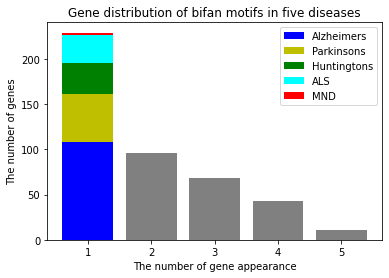

In [22]:
import matplotlib.pyplot as plt
import numpy as np
 
# create data
x = ['1', '2', '3', '4', '5']
y_all = np.array(count_genes_by_frequency)
y_all[0] = 0
y_Alzheimers = np.array([0, 0, 0, 0, 0])
y_Alzheimers[0] = count_unique_genes_by_disease['Alzheimers']
y_Parkinsons = np.array([0, 0, 0, 0, 0])
y_Parkinsons[0] = count_unique_genes_by_disease['Parkinsons']
y_Huntingtons = np.array([0, 0, 0, 0, 0])
y_Huntingtons[0] = count_unique_genes_by_disease['Huntingtons']
y_ALS = np.array([0, 0, 0, 0, 0])
y_ALS[0] = count_unique_genes_by_disease['ALS']
y_MND = np.array([0, 0, 0, 0, 0])
y_MND[0] = count_unique_genes_by_disease['MND']

# plot bars in stack manner
plt.bar(x, y_Alzheimers, color='b')
plt.bar(x, y_Parkinsons, bottom=y_Alzheimers, color='y')
plt.bar(x, y_Huntingtons, bottom=y_Alzheimers+y_Parkinsons, color='g')
plt.bar(x, y_ALS, bottom=y_Alzheimers+y_Parkinsons+y_Huntingtons, color='cyan')
plt.bar(x, y_MND, bottom=y_Alzheimers+y_Parkinsons+y_Huntingtons+y_ALS, color='r')
plt.bar(x, y_all, color='gray')
ax = plt.gca()
#ax.set_ylim([0, 150])
plt.ylabel("The number of genes")
plt.xlabel("The number of gene appearance")
plt.legend(["Alzheimers", "Parkinsons", "Huntingtons", "ALS", "MND"])
plt.title("Gene distribution of "+ motif_type+" motifs in five diseases")
plt.show()

# Experiment 3 - Statistical significance

In [134]:
# generate random graphs

disease_list = ['Alzheimers', 'Parkinsons', 'Huntingtons', 'ALS', 'MND']

for disease in disease_list:
    for index in range(0, 100):
        file_name = '../../dataset/real/' + 'OR' + "_minGDA_" + '0.0' + "_" + disease + ".txt"
        weightG = {}
        edge_lst = []
        with open(file_name) as f:
            while (True):
                s = f.readline()
                if s == '':
                    break

                lst = list(s[:-1].split(" "))
                #print(lst)
                edge_lst.append((int(lst[0]), int(lst[1])))
                #print(lst)
                weightG[(int(lst[0]), int(lst[1]))] = int(lst[2])
        G = nx.Graph()
        G.add_edges_from(edge_lst)
        new_edges = []
        for i in range(len(edge_lst)):
            ed_0 = random.choice(list(G.nodes))
            ed_1 = random.choice(list(G.nodes))
            while not (ed_0, ed_1) in new_edges and ed_0 == ed_1:
                ed_0 = random.choice(list(G.nodes))
                ed_1 = random.choice(list(G.nodes))
            new_edges.append((ed_0, ed_1))
            #print(ed_0, ed_1)
        outpath = '../../dataset/real/random_graphs/'+disease+'/'+str(index)+'.txt'
        with open(outpath, 'w') as f:
            for ed in new_edges:
                f.write(str(ed[0])+' '+str(ed[1])+'\n')

In [25]:
import statistics

motif_list = ['Cascade', 'FFL', 'Bifan', 'Biparallel']
motif_list_lowercase = ['cascade', 'FFL', 'bifan', 'biparallel']
for disease in disease_list:
    countt = 0
    for motif in motif_list:
        nums_motifs = -1
        motif_ = motif_list_lowercase[countt]
        countt += 1
        for record in all_res[motif_]:
            if record['disease'] == disease:
                nums_motifs = record['nums_motifs']
                break
        saved = []
        path = '../../dataset/real/random_results/Random_'+disease+'_'+motif+'_Results.txt'
        with open(path, 'r') as f:
            while True:
                line = f.readline()
                if line == '':
                    break
                saved.append(int(line[:-1].split('\t')[1]))
        saved_std = statistics.pstdev(saved)
        saved_mean = statistics.mean(saved)
        print(disease,motif,(nums_motifs - saved_mean)/saved_std)
        #print(saved, nums_motifs)

Alzheimers Cascade -0.26438635111017433
Alzheimers FFL 6.931679628465463
Alzheimers Bifan 14.587175915727018
Alzheimers Biparallel -0.44267571232971664
Parkinsons Cascade -0.08677789592263543
Parkinsons FFL 8.807564172304591
Parkinsons Bifan 14.042873445861312
Parkinsons Biparallel 0.9179559198227712
Huntingtons Cascade 1.6234787014920702
Huntingtons FFL 5.9027745760027575
Huntingtons Bifan 14.633487211372575
Huntingtons Biparallel -0.21320376964793292
ALS Cascade 0.5
ALS FFL 5.0245016939552825
ALS Bifan 11.15543552317528
ALS Biparallel -1.1153236152450732
MND Cascade -0.0503154605426628
MND FFL -0.011704916453677069
MND Bifan 4.009739135281762
MND Biparallel -0.8812010746015723
